In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import cv2

In [2]:
dirname = os.path.join(os.getcwd(), 'train')
imgpath = dirname + os.sep 
 
images = []
directories = []
dircount = []
prevRoot=''
cant=0
 
print("leyendo imagenes de ",imgpath)
 
for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)
 
dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  C:\Users\Carlos\Documents\Reconocimiento de imagenes\train\
C:\Users\Carlos\Documents\Reconocimiento de imagenes\train\CLASS_02 1
C:\Users\Carlos\Documents\Reconocimiento de imagenes\train\CLASS_03 62
C:\Users\Carlos\Documents\Reconocimiento de imagenes\train\CLASS_04 213
C:\Users\Carlos\Documents\Reconocimiento de imagenes\train\CLASS_05 105
C:\Users\Carlos\Documents\Reconocimiento de imagenes\train\CLASS_06 949
C:\Users\Carlos\Documents\Reconocimiento de imagenes\train\CLASS_07 36
C:\Users\Carlos\Documents\Reconocimiento de imagenes\train\CLASS_08 204
Directorios leidos: 7
Imagenes en cada directorio [63, 213, 105, 949, 36, 204, 62]
suma Total de imagenes en subdirs: 1632


In [3]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))
 
Tipo_Carnes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    Tipo_Carnes.append(name[len(name)-1])
    indice=indice+1
 
y = np.array(labels)
X = np.array(images, dtype=np.uint8) 
 
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Cantidad etiquetas creadas:  1632
0 CLASS_02
1 CLASS_03
2 CLASS_04
3 CLASS_05
4 CLASS_06
5 CLASS_07
6 CLASS_08
Total number of outputs :  7
Output classes :  [0 1 2 3 4 5 6]


In [4]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)
 
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.
 
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])
 
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)
 
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

Training data shape :  (1305, 216, 384, 3) (1305,)
Testing data shape :  (327, 216, 384, 3) (327,)
Original label: 3
After conversion to one-hot: [0. 0. 0. 1. 0. 0. 0.]
(1044, 216, 384, 3) (261, 216, 384, 3) (1044, 7) (261, 7)


In [5]:
INIT_LR = 1e-3
epochs = 15
batch_size = 64

carnes_model = Sequential()
carnes_model.add(Conv2D(35, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(216,384,3)))
carnes_model.add(LeakyReLU(alpha=0.1))
carnes_model.add(MaxPooling2D((2, 2),padding='same'))
carnes_model.add(Dropout(0.5))

carnes_model.add(Flatten())
carnes_model.add(Dense(35, activation='linear'))
carnes_model.add(LeakyReLU(alpha=0.1))
carnes_model.add(Dropout(0.5)) 
carnes_model.add(Dense(nClasses, activation='softmax'))

carnes_model.summary()

carnes_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(learning_rate=INIT_LR), metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 216, 384, 35)      980       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 216, 384, 35)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 108, 192, 35)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 108, 192, 35)      0         
                                                                 
 flatten (Flatten)           (None, 725760)            0         
                                                                 
 dense (Dense)               (None, 35)                25401635  
                                                        

In [6]:
""""### Redimensionar todas las imágenes de entrenamiento y validación a (21, 28)
train_X_resized = []
for image in train_X:
    resized_image = cv2.resize(image, (28, 21))
    train_X_resized.append(resized_image)

train_X_resized = np.array(train_X_resized)

valid_X_resized = []
for image in valid_X:
    resized_image = cv2.resize(image, (28, 21))
    valid_X_resized.append(resized_image)

valid_X_resized = np.array(valid_X_resized)  """

carnes_train_dropout = carnes_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
 
carnes_model.save("carnes_mnist.h5py")


Epoch 1/15
17/17 [==============================] - 88s 5s/step - loss: 1.9317 - accuracy: 0.5393 - val_loss: 1.8880 - val_accuracy: 0.5939
Epoch 2/15
17/17 [==============================] - 74s 4s/step - loss: 1.7890 - accuracy: 0.5603 - val_loss: 1.6114 - val_accuracy: 0.5939
Epoch 3/15
17/17 [==============================] - 72s 4s/step - loss: 1.5911 - accuracy: 0.5623 - val_loss: 1.4342 - val_accuracy: 0.5939
Epoch 4/15
17/17 [==============================] - 72s 4s/step - loss: 1.5260 - accuracy: 0.5642 - val_loss: 1.3956 - val_accuracy: 0.5939
Epoch 5/15
17/17 [==============================] - 75s 4s/step - loss: 1.4957 - accuracy: 0.5718 - val_loss: 1.3790 - val_accuracy: 0.5939
Epoch 6/15
17/17 [==============================] - 75s 4s/step - loss: 1.4951 - accuracy: 0.5575 - val_loss: 1.3623 - val_accuracy: 0.5939
Epoch 7/15
17/17 [==============================] - 77s 5s/step - loss: 1.4986 - accuracy: 0.5651 - val_loss: 1.3610 - val_accuracy: 0.5939
Epoch 8/15
17/17 [==

INFO:tensorflow:Assets written to: carnes_mnist.h5py\assets


In [7]:
""""print("Dimensiones de test_X:", test_X.shape)
print("Dimensiones de test_Y_one_hot:", test_Y_one_hot.shape)

batch_size = 32  # Puedes ajustar este valor según tu necesidad
height = 216
width = 384
channels = 3  # Esto puede variar según tu modelo

# Redimensiona test_X para que coincida con las dimensiones de entrada
test_X_reshaped = np.reshape(test_X, (test_X.shape[0], height, width, channels))

# Verifica las dimensiones después de la redimensión
print("Dimensiones de test_X redimensionado:", test_X_reshaped.shape)"""
test_eval = carnes_model.evaluate(test_X, test_Y_one_hot, verbose=1)
 
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])



11/11 [==============================] - 6s 492ms/step - loss: 1.3693 - accuracy: 0.5902
Test loss: 1.3692677021026611
Test accuracy: 0.5902140736579895


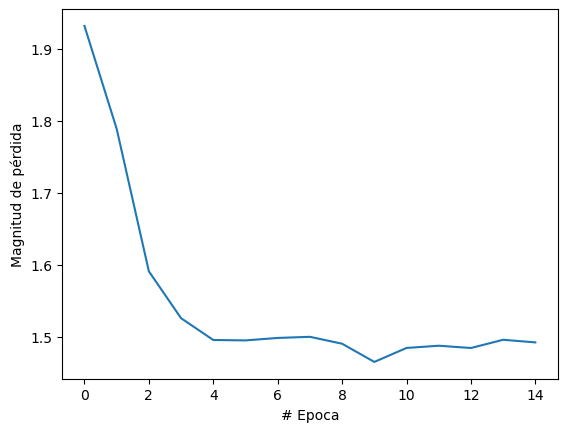

In [11]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(carnes_train_dropout.history["loss"])